Please run the following block to ensure TVM is setup for *this notebook*, each notebook may have its own runtime.



In [1]:
! gsutil cp "gs://tvm-fcrc-binariesd5fce43e-8373-11e9-bfb6-0242ac1c0002/tvm.tar.gz" /tmp/tvm.tar.gz
! mkdir -p /tvm
! tar -xf /tmp/tvm.tar.gz --strip-components=4 --directory /tvm
! ls -la /tvm
# Move this block after we are done with pkg step
! bash /tvm/package.sh
import sys
sys.path.append('/tvm/python')
sys.path.append('/tvm/topi/python')

Copying gs://tvm-fcrc-binariesd5fce43e-8373-11e9-bfb6-0242ac1c0002/tvm.tar.gz...
- [1 files][119.5 MiB/119.5 MiB]                                                
Operation completed over 1 objects/119.5 MiB.                                    
total 164
drwxr-xr-x 21 root root  4096 Sep 23 08:21 .
drwxr-xr-x  1 root root  4096 Sep 23 08:21 ..
drwx------  8 root root  4096 May 31  2019 3rdparty
drwx------ 12 root root  4096 May 31  2019 apps
drwx------  3 root root  4096 Jun 19  2019 build
drwx------  4 root root  4096 May 31  2019 cmake
-rw-------  1 root root 11053 Jun 19  2019 CMakeLists.txt
drwx------  6 root root  4096 May 31  2019 conda
-rw-------  1 root root  5736 Jun 19  2019 CONTRIBUTORS.md
drwx------  3 root root  4096 May 31  2019 docker
drwx------ 11 root root  4096 May 31  2019 docs
drwx------  4 root root  4096 May 31  2019 golang
drwx------  3 root root  4096 May 31  2019 include
-rw-------  1 root root 10607 Jun 19  2019 Jenkinsfile
drwx------  6 root root  4096 May 31 

Import packages:

In [2]:
import logging
import sys
import numpy as np

import tvm
import topi
from topi.testing import conv2d_nchw_python

from tvm import autotvm

Step 0: Vanilla direct 2D convolution implementation without a tunable template
---------------------------------------------------------------------------------------------

We reuse the conv2d with NCHW data layout in the TVM operator inventory (TOPI).
This definition gives us the default schedule (loop nest) seen below.


In [3]:
# the last layer in resnet
N, H, W, CO, CI, KH, KW, stride, padding = 1, 7, 7, 512, 512, 3, 3, (1, 1), (1, 1)
assert N == 1, "Only consider batch_size = 1 in this template"

data = tvm.placeholder((N, CI, H, W), name='data')
kernel = tvm.placeholder((CO, CI, KH, KW), name='kernel')
conv = topi.nn.conv2d_nchw(data, kernel, stride, padding, dilation=1, out_dtype='float32')
s = tvm.create_schedule([conv.op])
print("Default Schedule:")
print(tvm.lower(s, [data, kernel, conv], simple_mode=True))

# assign axes of the default schedule to variables
n, f, y, x = s[conv].op.axis
rc, ry, rx = s[conv].op.reduce_axis

Default Schedule:
// attr [pad_temp] storage_scope = "global"
allocate pad_temp[float32 * 41472]
produce pad_temp {
  for (i1, 0, 512) {
    for (i2, 0, 9) {
      for (i3, 0, 9) {
        pad_temp[((((i1*9) + i2)*9) + i3)] = tvm_if_then_else(((((1 <= i2) && (i2 < 8)) && (1 <= i3)) && (i3 < 8)), data[(((((i1*7) + i2)*7) + i3) + -8)], 0.000000f)
      }
    }
  }
}
produce compute {
  for (ff, 0, 512) {
    for (yy, 0, 7) {
      for (xx, 0, 7) {
        compute[((((ff*7) + yy)*7) + xx)] = 0.000000f
        for (rc, 0, 512) {
          for (ry, 0, 3) {
            for (rx, 0, 3) {
              compute[((((ff*7) + yy)*7) + xx)] = (compute[((((ff*7) + yy)*7) + xx)] + (pad_temp[((((((rc*9) + yy) + ry)*9) + xx) + rx)]*kernel[((((((ff*512) + rc)*3) + ry)*3) + rx)]))
            }
          }
        }
      }
    }
  }
}



Here, we inline padding into the computation (as opposed to padding in the input in a second operator) and declare cache stages. Cache stages are prepare a subset of the input (read) or output (write) for improved temporal locality with higher performance memories (e.g., registers and shared memory vs. global memory).

In [4]:
# inline padding
pad_data = s[conv].op.input_tensors[0]
s[pad_data].compute_inline()
input = data
data, raw_data = pad_data, data

output = conv
OL = s.cache_write(conv, 'local')

# create cache stage
AA = s.cache_read(data, 'shared', [OL])
WW = s.cache_read(kernel, 'shared', [OL])
AL = s.cache_read(AA, 'local', [OL])
WL = s.cache_read(WW, 'local', [OL])

print(tvm.lower(s, [input, kernel, conv], simple_mode=True))

// attr [pad_temp.shared] storage_scope = "shared"
allocate pad_temp.shared[float32 * 41472]
// attr [pad_temp.shared.local] storage_scope = "local"
allocate pad_temp.shared.local[float32 * 41472]
// attr [kernel.shared] storage_scope = "shared"
allocate kernel.shared[float32 * 2359296]
// attr [kernel.shared.local] storage_scope = "local"
allocate kernel.shared.local[float32 * 2359296]
// attr [compute.local] storage_scope = "local"
allocate compute.local[float32 * 25088]
produce pad_temp.shared {
  for (ax1, 0, 512) {
    for (ax2, 0, 9) {
      for (ax3, 0, 9) {
        pad_temp.shared[((((ax1*9) + ax2)*9) + ax3)] = tvm_if_then_else(((((1 <= ax2) && (ax2 < 8)) && (1 <= ax3)) && (ax3 < 8)), data[(((((ax1*7) + ax2)*7) + ax3) + -8)], 0.000000f)
      }
    }
  }
}
produce pad_temp.shared.local {
  for (ax1, 0, 512) {
    for (ax2, 0, 9) {
      for (ax3, 0, 9) {
        pad_temp.shared.local[((((ax1*9) + ax2)*9) + ax3)] = pad_temp.shared[((((ax1*9) + ax2)*9) + ax3)]
      }
    }
  }
}

Here, we first grab the spatial axes from the schedule. Next, we define several magic numbers that are tiling factors that we use to split the original loop nest into one with several additional levels. We reorder the levels to redefine the computation order (and the memory access order) or the computation. As we will see in the next cell, this transformation also readies the schedule for a mapping from loop nests to GPU computation indicies (grids, blocks, threads).

In [5]:
# tile spatial axes
n, f, y, x = s[output].op.axis
tile_f_factors = [8, 8, 8, 1]
tile_x_factors = [7, 7, 7, 1]
tile_y_factors = [7, 7, 7, 1]

bf, vf = s[output].split(f, factor=tile_f_factors[1])
vf, tf = s[output].split(vf, factor=tile_f_factors[2])
tf, fi = s[output].split(tf, factor=tile_f_factors[3])

by, vy = s[output].split(y, factor=tile_y_factors[1])
vy, ty = s[output].split(vy, factor=tile_y_factors[2])
ty, yi = s[output].split(ty, factor=tile_y_factors[3])

bx, vx = s[output].split(x, factor=tile_x_factors[1])
vx, tx = s[output].split(vx, factor=tile_x_factors[2])
tx, xi, = s[output].split(tx, factor=tile_x_factors[3])

kernel_scope = n  # this is the scope to attach global config inside this kernel

s[output].reorder(n, bf, by, bx, vf, vy, vx, tf, ty, tx, fi, yi, xi)
print(tvm.lower(s, [input, kernel, conv], simple_mode=True))

// attr [pad_temp.shared] storage_scope = "shared"
allocate pad_temp.shared[float32 * 41472]
// attr [pad_temp.shared.local] storage_scope = "local"
allocate pad_temp.shared.local[float32 * 41472]
// attr [kernel.shared] storage_scope = "shared"
allocate kernel.shared[float32 * 2359296]
// attr [kernel.shared.local] storage_scope = "local"
allocate kernel.shared.local[float32 * 2359296]
// attr [compute.local] storage_scope = "local"
allocate compute.local[float32 * 25088]
produce pad_temp.shared {
  for (ax1, 0, 512) {
    for (ax2, 0, 9) {
      for (ax3, 0, 9) {
        pad_temp.shared[((((ax1*9) + ax2)*9) + ax3)] = tvm_if_then_else(((((1 <= ax2) && (ax2 < 8)) && (1 <= ax3)) && (ax3 < 8)), data[(((((ax1*7) + ax2)*7) + ax3) + -8)], 0.000000f)
      }
    }
  }
}
produce pad_temp.shared.local {
  for (ax1, 0, 512) {
    for (ax2, 0, 9) {
      for (ax3, 0, 9) {
        pad_temp.shared.local[((((ax1*9) + ax2)*9) + ax3)] = pad_temp.shared[((((ax1*9) + ax2)*9) + ax3)]
      }
    }
  }
}

After reshaping the loop nest, we can bind portions of the computations to GPU blocks and threads. Additionally, we bind some loops to "virtual" threads which are effectively threads emulated in software. Virtual threads enable the expression of more sophisticated computation and memory access patterns vs. blocks and threads alone. Note binding effictively removes the associated loop axes from the schedule, as they are now parallelized based on their index instead.

In [6]:
s[output].bind(bf, tvm.thread_axis("blockIdx.z"))
s[output].bind(by, tvm.thread_axis("blockIdx.y"))
s[output].bind(bx, tvm.thread_axis("blockIdx.x"))
s[output].bind(vf, tvm.thread_axis("vthread"))
s[output].bind(vy, tvm.thread_axis("vthread"))
s[output].bind(vx, tvm.thread_axis("vthread"))
s[output].bind(tf, tvm.thread_axis("threadIdx.z"))
s[output].bind(ty, tvm.thread_axis("threadIdx.y"))
s[output].bind(tx, tvm.thread_axis("threadIdx.x"))
s[OL].compute_at(s[output], tx)
print(tvm.lower(s, [input, kernel, output], simple_mode=True))

// attr [pad_temp.shared] storage_scope = "shared"
allocate pad_temp.shared[float32 * 4608]
// attr [pad_temp.shared.local] storage_scope = "local"
allocate pad_temp.shared.local[float32 * 4608]
// attr [kernel.shared.local] storage_scope = "local"
allocate kernel.shared.local[float32 * 4608]
produce pad_temp.shared {
  for (ax1, 0, 512) {
    for (ax2, 0, 3) {
      for (ax3, 0, 3) {
        pad_temp.shared[((((ax1*3) + ax2)*3) + ax3)] = tvm_if_then_else((((((1 - threadIdx.y) <= ax2) && (ax2 < (8 - threadIdx.y))) && ((1 - threadIdx.x) <= ax3)) && (ax3 < (8 - threadIdx.x))), data[(((((((ax1*7) + ax2) + threadIdx.y)*7) + ax3) + threadIdx.x) + -8)], 0.000000f)
      }
    }
  }
}
produce pad_temp.shared.local {
  for (ax1, 0, 512) {
    for (ax2, 0, 3) {
      for (ax3, 0, 3) {
        pad_temp.shared.local[((((ax1*3) + ax2)*3) + ax3)] = pad_temp.shared[((((ax1*3) + ax2)*3) + ax3)]
      }
    }
  }
}
produce kernel.shared {
  for (ax1, 0, 512) {
    for (ax2, 0, 3) {
      for (ax3, 0, 

Next, we apply a tiling transformation over the reduction axes, using a series of loop axes splits followed by a reorder as in the previous case. With this arrangement of loop axes, we also define the points at which each cached tensor is prepared to be read or written with `compute_at`.

In [7]:
# tile reduction axes
n, f, y, x = s[OL].op.axis
rc, ry, rx = s[OL].op.reduce_axis
rc_factors = [512, 32, 1]
rx_factors = [3, 3, 1]
ry_factors = [3, 3, 1]
rco, rcm = s[OL].split(rc, factor=rc_factors[1])
rcm, rci = s[OL].split(rcm, factor=rc_factors[2])
ryo, rym = s[OL].split(ry, factor=ry_factors[1])
rym, ryi = s[OL].split(rym, factor=ry_factors[2])
rxo, rxm = s[OL].split(rx, factor=rx_factors[1])
rxm, rxi = s[OL].split(rxm, factor=rx_factors[2])
s[OL].reorder(rco, ryo, rxo, rcm, rym, rxm, rci, ryi, rxi, n, f, y, x)

s[AA].compute_at(s[OL], rxo)
s[WW].compute_at(s[OL], rxo)
s[AL].compute_at(s[OL], rxm)
s[WL].compute_at(s[OL], rxm)

print(tvm.lower(s, [input, kernel, output], simple_mode=True))

produce compute {
  // attr [iter_var(blockIdx.z, , blockIdx.z)] thread_extent = 64
  // attr [compute.local] storage_scope = "local"
  allocate compute.local[float32 * 1]
  // attr [pad_temp.shared] storage_scope = "shared"
  allocate pad_temp.shared[float32 * 2592]
  // attr [kernel.shared] storage_scope = "shared"
  allocate kernel.shared[float32 * 2304]
  // attr [pad_temp.shared.local] storage_scope = "local"
  allocate pad_temp.shared.local[float32 * 1]
  // attr [kernel.shared.local] storage_scope = "local"
  allocate kernel.shared.local[float32 * 1]
  // attr [iter_var(blockIdx.y, , blockIdx.y)] thread_extent = 1
  // attr [iter_var(blockIdx.x, , blockIdx.x)] thread_extent = 1
  // attr [iter_var(threadIdx.z, , threadIdx.z)] thread_extent = 8
  // attr [iter_var(threadIdx.y, , threadIdx.y)] thread_extent = 7
  // attr [iter_var(threadIdx.x, , threadIdx.x)] thread_extent = 7
  produce compute.local {
    compute.local[0] = 0.000000f
    for (rc.outer, 0, 16) {
      produce pad_

Next, we schedule the cooperative fetching of data and weighs for the threads in each thread block. We use the `bind` schedule primitive as before, with the main difference being that we must split the thread axes to match the number of threads that have already been declared in the prevous spatial tiling step.
For simplicity, we omit the specification of compiler directives (e.g., loop unrolling) in this part of the tutorial---we include them when showing the full AutoTVM tuining example.

In [8]:
# cooperative fetching
for load in [AA, WW]:
    n, f, y, x = s[load].op.axis 
    fused = s[load].fuse(n, f, y, x)
    tz, fused = s[load].split(fused, nparts=tile_f_factors[2])
    ty, fused = s[load].split(fused, nparts=tile_y_factors[2])
    tx, fused = s[load].split(fused, nparts=tile_x_factors[2])
    s[load].bind(tz, tvm.thread_axis("threadIdx.z"))
    s[load].bind(ty, tvm.thread_axis("threadIdx.y"))
    s[load].bind(tx, tvm.thread_axis("threadIdx.x"))
print(tvm.lower(s, [input, kernel, output], simple_mode=True))
# tune unroll
#s[output].pragma(kernel_scope, 'auto_unroll_max_step', cfg['auto_unroll_max_step'].val)
#s[output].pragma(kernel_scope, 'unroll_explicit', cfg['unroll_explicit'].val)

produce compute {
  // attr [iter_var(blockIdx.z, , blockIdx.z)] thread_extent = 64
  // attr [compute.local] storage_scope = "local"
  allocate compute.local[float32 * 1]
  // attr [pad_temp.shared] storage_scope = "shared"
  allocate pad_temp.shared[float32 * 2592]
  // attr [kernel.shared] storage_scope = "shared"
  allocate kernel.shared[float32 * 2304]
  // attr [pad_temp.shared.local] storage_scope = "local"
  allocate pad_temp.shared.local[float32 * 1]
  // attr [kernel.shared.local] storage_scope = "local"
  allocate kernel.shared.local[float32 * 1]
  // attr [iter_var(blockIdx.y, , blockIdx.y)] thread_extent = 1
  // attr [iter_var(blockIdx.x, , blockIdx.x)] thread_extent = 1
  // attr [iter_var(threadIdx.z, , threadIdx.z)] thread_extent = 8
  // attr [iter_var(threadIdx.y, , threadIdx.y)] thread_extent = 7
  // attr [iter_var(threadIdx.x, , threadIdx.x)] thread_extent = 7
  produce compute.local {
    compute.local[0] = 0.000000f
    for (rc.outer, 0, 16) {
      produce pad_

Finally, we run a reference implementation to generate reference results to check the correctness of the scheduled code and measure the performance of the scheduled code.

In [9]:
# check correctness
a_np = np.random.uniform(size=(N, CI, H, W)).astype(np.float32)
w_np = np.random.uniform(size=(CO, CI, KH, KW)).astype(np.float32)
c_np = conv2d_nchw_python(a_np, w_np, stride, padding)

# compile the manually schedule convolution
with tvm.target.create('cuda'):
    manual_conv2d = tvm.build(s, [input, kernel, output])
    
ctx = tvm.gpu()
a_tvm = tvm.nd.array(a_np, ctx=ctx)
w_tvm = tvm.nd.array(w_np, ctx=ctx)
c_tvm = tvm.nd.empty(c_np.shape, ctx=ctx)
manual_conv2d(a_tvm, w_tvm, c_tvm)

tvm.testing.assert_allclose(c_np, c_tvm.asnumpy(), rtol=1e-2)

evaluator = manual_conv2d.time_evaluator(manual_conv2d.entry_name, ctx, number=400)
mean = evaluator(a_tvm, w_tvm, c_tvm).mean
print("complexity: ", autotvm.task.task.compute_flop(s))
print("Time cost of this operator: %f" % mean)
manual_flops = autotvm.task.task.compute_flop(s)/mean
print("GFLOPS:", manual_flops/1e9)

complexity:  231501312
Time cost of this operator: 0.001017
GFLOPS: 227.5949809918468


Using a schedule template instead of a manually defined schedule
====================================================

Next, we show that we can avoid the magic numbers used previously and instead leave them as free variables to be decided by a tuner. This change relieves the burden of tuning on the schedule writer and also potentially opens up a much large space for optimization.

From a high level schedule template is identical to the manual schedule defined previously, with hardcoded values replaced with configuration option declarations. Note that AutoTVM also provides some syntactic sugar for splitting (using `define_split`) a single axis into multiple axes at once with the `num_outputs` parameter, instead of only splitting each axis into two each time with `split`. Also note that each configuration option is now applied with calls to `cfg[...].apply(...)`.

Note that we wrap the schedule in a function to leverage the `@autotvm.template` decorator for automated tuning.
Tunable parameters that were previously manually specified are now passed using the `cfg` variable in the schedule.

In [10]:
@autotvm.template
def conv2d_no_batching(N, H, W, CO, CI, KH, KW, stride, padding):
    assert N == 1, "Only consider batch_size = 1 in this template"

    data = tvm.placeholder((N, CI, H, W), name='data')
    kernel = tvm.placeholder((CO, CI, KH, KW), name='kernel')
    conv = topi.nn.conv2d_nchw(data, kernel, stride, padding, dilation=1, out_dtype='float32')
    s = tvm.create_schedule([conv.op])

    ##### space definition begin #####
    n, f, y, x = s[conv].op.axis
    rc, ry, rx = s[conv].op.reduce_axis

    cfg = autotvm.get_config()
    cfg.define_split("tile_f", f, num_outputs=4)
    cfg.define_split("tile_y", y, num_outputs=4)
    cfg.define_split("tile_x", x, num_outputs=4)
    cfg.define_split("tile_rc", rc, num_outputs=3)
    cfg.define_split("tile_ry", ry, num_outputs=3)
    cfg.define_split("tile_rx", rx, num_outputs=3)
    cfg.define_knob("auto_unroll_max_step", [0, 512, 1500])
    cfg.define_knob("unroll_explicit", [0, 1])
    ##### space definition end #####

    # inline padding
    pad_data = s[conv].op.input_tensors[0]
    s[pad_data].compute_inline()
    data, raw_data = pad_data, data

    output = conv
    OL = s.cache_write(conv, 'local')

    # create cache stage
    AA = s.cache_read(data, 'shared', [OL])
    WW = s.cache_read(kernel, 'shared', [OL])
    AL = s.cache_read(AA, 'local', [OL])
    WL = s.cache_read(WW, 'local', [OL])

    # tile and bind spatial axes
    n, f, y, x = s[output].op.axis
    bf, vf, tf, fi = cfg["tile_f"].apply(s, output, f)
    by, vy, ty, yi = cfg["tile_y"].apply(s, output, y)
    bx, vx, tx, xi = cfg["tile_x"].apply(s, output, x)
    kernel_scope = n  # this is the scope to attach global config inside this kernel

    s[output].bind(bf, tvm.thread_axis("blockIdx.z"))
    s[output].bind(by, tvm.thread_axis("blockIdx.y"))
    s[output].bind(bx, tvm.thread_axis("blockIdx.x"))
    s[output].bind(vf, tvm.thread_axis("vthread"))
    s[output].bind(vy, tvm.thread_axis("vthread"))
    s[output].bind(vx, tvm.thread_axis("vthread"))
    s[output].bind(tf, tvm.thread_axis("threadIdx.z"))
    s[output].bind(ty, tvm.thread_axis("threadIdx.y"))
    s[output].bind(tx, tvm.thread_axis("threadIdx.x"))
    s[output].reorder(n, bf, by, bx, vf, vy, vx, tf, ty, tx, fi, yi, xi)
    s[OL].compute_at(s[output], tx)

    # tile reduction axes
    n, f, y, x = s[OL].op.axis
    rc, ry, rx = s[OL].op.reduce_axis
    rco, rcm, rci = cfg['tile_rc'].apply(s, OL, rc)
    ryo, rym, ryi = cfg['tile_rx'].apply(s, OL, ry)
    rxo, rxm, rxi = cfg['tile_ry'].apply(s, OL, rx)
    s[OL].reorder(rco, ryo, rxo, rcm, rym, rxm, rci, ryi, rxi, n, f, y, x)

    s[AA].compute_at(s[OL], rxo)
    s[WW].compute_at(s[OL], rxo)
    s[AL].compute_at(s[OL], rxm)
    s[WL].compute_at(s[OL], rxm)

    # cooperative fetching
    for load in [AA, WW]:
        n, f, y, x = s[load].op.axis
        fused = s[load].fuse(n, f, y, x)
        tz, fused = s[load].split(fused, nparts=cfg["tile_f"].size[2])
        ty, fused = s[load].split(fused, nparts=cfg["tile_y"].size[2])
        tx, fused = s[load].split(fused, nparts=cfg["tile_x"].size[2])
        s[load].bind(tz, tvm.thread_axis("threadIdx.z"))
        s[load].bind(ty, tvm.thread_axis("threadIdx.y"))
        s[load].bind(tx, tvm.thread_axis("threadIdx.x"))

    # tune unroll
    s[output].pragma(kernel_scope, 'auto_unroll_max_step', cfg['auto_unroll_max_step'].val)
    s[output].pragma(kernel_scope, 'unroll_explicit', cfg['unroll_explicit'].val)

    return s, [raw_data, kernel, conv]

Start Infrastructure for Tuning (tracker)
===============================
AutoTVM leverages the TVM RPC system to abstract and multiplex the actual hardware tuning targets. TVM RPC provides a tracker that distributes hardware resources so that multiple tuning jobs can share a pool of hardware devices. In this case we start a tracker instance on the machine running the laboratory notebook.

In [11]:
%%script bash --bg --out output --err error
PYTHONPATH=/tvm/python:$PYTHONPATH && python3 -m tvm.exec.rpc_tracker --host 0.0.0.0 --port 9190 &
while true; do
  res=$(PYTHONPATH=/tvm/python:$PYTHONPATH && python3 -m tvm.exec.query_rpc_tracker --host 0.0.0.0 --port 9190 2>&1 | grep 'Cannot connect to tracker')
  if [ "$res" == "" ]; then
    echo "OK @ " $(date) "..." >> status.log
  else
    echo "RESTARTING @ " $(date) "..." >> status.log
    PYTHONPATH=/tvm/python:$PYTHONPATH && python3 -m tvm.exec.rpc_tracker --host 0.0.0.0 --port 9190 &
  fi
  sleep 5
done

Start Infrastructure for Tuning (server)
===============================
We then start an RPC server instance that manages this notebook's GPU, and configure it to report to the tracker.

In [12]:
%%script bash --bg --out output2 --err error2
while true; do
echo "started server at " $(date) >> status.log
PYTHONPATH=/tvm/python:/tvm/topi/python:$PYTHONPATH && python3 -m tvm.exec.rpc_server --key 1080ti --tracker 0.0.0.0:9190
sleep 30
done

Check the status of the tracker
=========================

In [13]:
! cat status.log | tail
! PYTHONPATH=/tvm/python:$PYTHONPATH && python3 -m tvm.exec.query_rpc_tracker --host 0.0.0.0 --port 9190 

started server at  Fri Sep 23 08:22:07 UTC 2022
Tracker address 0.0.0.0:9190

Server List
----------------------------
server-address	key
----------------------------
127.0.0.1:44002	server:1080ti
----------------------------

Queue Status
------------------------------
key      total  free  pending
------------------------------
1080ti   1      1     0      
------------------------------



In [14]:
peak = 0.0
count = 0
from matplotlib import pyplot as plt
from IPython.display import clear_output

def plot_callback():
  y = list()
  x = list()
  fig,ax = plt.subplots(1,1)
  def _callback(_, inputs, results):
    global peak
    global count
    for inp, res in zip(inputs, results):
      count += 1
      if res.error_no == 0:
        cost = np.mean(res.costs)
        perf = inp.task.flop/cost
        if perf > peak:
          print("reached new peak: {:.2f} GFLOPS".format(perf/1e9))
          peak = perf
      x.append(count)
      y.append(peak)
      if count % 8 == 0:
        plt.plot(x, y)
        plt.axhline(y=manual_flops, color='r', linestyle=':', label='manual baseline')
        plt.ylabel('performance (FLOP/S)')
        plt.xlabel('trials run')
        plt.legend()
        clear_output()
        plt.show()
  return _callback

Launch the Tuning Process
========================
We first acquire a logger to show the results of tuning and define the tuning task to be the last convolutional layer of resnet-18.
The remaining code is boilerplate for specifying tuning options, specifying that we are running tuning over RPC and the target RPC device type and timeouts for building and running schedule configurations. Finally, we launch the tuning job with `tuner.tune()`, passing the number of trials (number of configurations to profile) that we want to allocate for tuning.


Note that due to the balance of CPU and GPU resources on colab notebook runtimes, we use XGB `knob` features, which are much less CPU intensive to compute than `itervar` features. However, `itervar` features remain useful when we want to leverage transfer learning for efficient tuning across multiple tuning jobs.

Finally, we recommend using dedicated hardware resources for full-scale tuning experiments, as the stability of colab notebook runtimes and tuning is uncertain over long time periods in our experience.

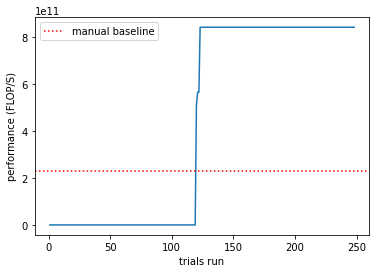

In [ ]:
# logging config (for printing tuning log to screen)
#logging.getLogger('autotvm').setLevel(logging.DEBUG)
#logging.getLogger('autotvm').addHandler(logging.StreamHandler(sys.stdout))

# the last layer in resnet
N, H, W, CO, CI, KH, KW, strides, padding = 1, 7, 7, 512, 512, 3, 3, (1, 1), (1, 1)
task = autotvm.task.create(conv2d_no_batching,
                           args=(N, H, W, CO, CI, KH, KW, strides, padding),
                           target='cuda')

# Use local gpu, measure 10 times for every config to reduce variance
# The timeout of compiling a program is 10 seconds, the timeout for running is 4 seconds
measure_option = autotvm.measure_option(
    builder=autotvm.LocalBuilder(),
            runner=autotvm.RPCRunner(
            '1080ti',  # change the device key to your key
            '0.0.0.0', 9190,
            number=256, repeat=3, timeout=1, min_repeat_ms=50)
)

# Begin tuning, log records to file `conv2d.log`
# During tuning we will also try many invalid configs, so you are expected to
# see many error reports. As long as you can see non-zero GFLOPS, it is okay.
tuner = autotvm.tuner.XGBTuner(task, feature_type='knob')
tuner.tune(n_trial=512,
           measure_option=measure_option,
           callbacks=[plot_callback()])
           #callbacks=[autotvm.callback.log_to_file('conv2d.log'), plot_callback()])

Conclusion
-------------------
We showed how to lift a schedule for an operator (direct convolution on GPU) to a schedule template, which defines a search spaces of possible implementations using the direct strategy on a GPU. We then tuned the operator to achieve better performance than a manually written schedule with hardcoded parameters. Crucially, tuning is automatic across many different operator shapes and and variants.